In [1]:
import keras
import numpy as np
import pretty_midi
import librosa
import glob
import os
import matplotlib.pyplot as plt
import librosa.display
import IPython.display as ipd
from train_util import NoteIsoSequence
from train_util import program_map, one_hot_map
import scipy

# synthesize without label and then add back for train?
# loud not at the end to force normalization?

Using TensorFlow backend.


In [2]:
midi_root_dir = "/home/faraaz/workspace/music-transcription/data/clean_midi/"
midi_files = glob.iglob(os.path.join(midi_root_dir, '**', '*.mid'))
midi_file = next(midi_files)
print(midi_file)

/home/faraaz/workspace/music-transcription/data/clean_midi/Redbone/Come and Get Your Love.mid


In [3]:
sf2_path="/usr/share/sounds/sf2/FluidR3_GM.sf2"
sample_rate = 32000
sample_duration = 2 * sample_rate
n_fft = 2048
hop_length = int(n_fft / 4)
epsilon = 0.00001
pm = pretty_midi.PrettyMIDI(midi_file)
pm_samples = pm.fluidsynth(fs=sample_rate, sf2_path=sf2_path)

In [4]:
instr_id = 0
note_id = 0
instrument = pm.instruments[instr_id]
print(instrument.notes[note_id])
note = instrument.notes[note_id]
sample_start = int(note.start * sample_rate)

Note(start=51.199068, end=51.318113, pitch=81, velocity=105)


In [5]:
padded_samples = pm_samples[:]
if len(padded_samples > sample_start+sample_duration):
    print("hi")
    print(pm_samples.shape)
    padded_samples = padded_samples[sample_start:sample_start+sample_duration]
if len(padded_samples) < sample_duration:
    padded_samples = np.pad(padded_samples, (0, sample_duration-len(padded_samples)), 
                                'constant', constant_values=(0,0))

hi
(10043769,)


In [6]:
print(padded_samples.shape)
print(padded_samples[-1])
ipd.Audio(padded_samples, rate=sample_rate)

(64000,)
-0.05516061084781464


(1025, 126)
(0.01231394+0j)


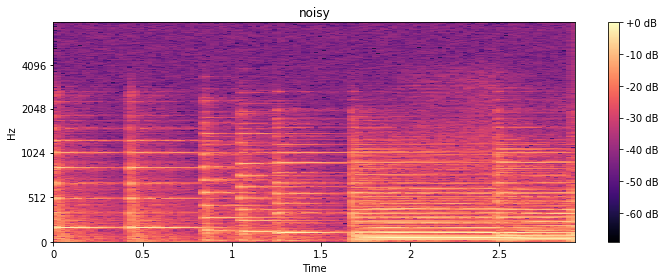

In [7]:
noisy_stft = librosa.core.stft(y=padded_samples, n_fft=n_fft, hop_length=hop_length)
print(noisy_stft.shape)
plt.figure(figsize=(10, 4))
librosa.display.specshow(librosa.power_to_db(np.abs(noisy_stft), ref=np.max), 
                         y_axis='mel', fmax=8000, x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('noisy')
plt.tight_layout()
print(noisy_stft[-1][-1])

In [8]:
final_noisy = np.stack((noisy_stft.real, noisy_stft.imag), axis=2)
print(final_noisy.shape)

(1025, 126, 2)


In [9]:
annotation = np.zeros((1, final_noisy.shape[1], final_noisy.shape[2]))
print(annotation.shape)
annotation[0,0,0] = note.pitch  # TODO: make this one hot encoding
annotation[0,0,1] = note.end - note.start  # TODO: scale this
final_input = np.append(final_noisy, annotation, axis=0)
print(final_input.shape)

(1, 126, 2)
(1026, 126, 2)


In [10]:
pm_iso = pretty_midi.PrettyMIDI()
iso_instrument = pretty_midi.Instrument(instrument.program, is_drum=instrument.is_drum)
iso_note = pretty_midi.Note(note.velocity, note.pitch, 0.0, 1)
iso_instrument.notes = [iso_note]
pm_iso.instruments = [iso_instrument]

pm_iso_samples = pm_iso.fluidsynth(fs=sample_rate, sf2_path=sf2_path)
if len(pm_iso_samples) > sample_duration:
    pm_iso_samples = pm_iso_samples[:sample_duration]
if len(pm_iso_samples) < sample_duration:
    pm_iso_samples = np.pad(pm_iso_samples, (0, sample_duration-len(pm_iso_samples)), 
                            'constant', constant_values=(0,0))

ipd.Audio(pm_iso_samples, rate=sample_rate)

(1025, 126)


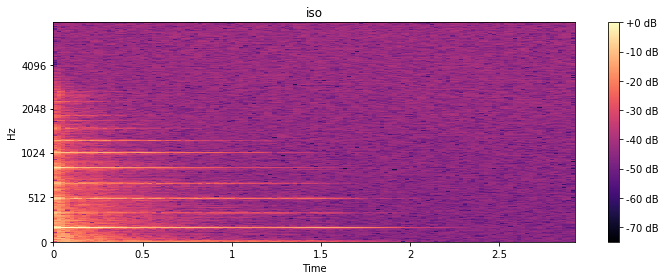

In [11]:
iso_stft = librosa.core.stft(y=pm_iso_samples, n_fft=n_fft, hop_length=hop_length)
print(iso_stft.shape)
plt.figure(figsize=(10, 4))
librosa.display.specshow(librosa.power_to_db(np.abs(iso_stft), ref=np.max), 
                         y_axis='mel', fmax=8000, x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('iso')
plt.tight_layout()

In [12]:
# convert complex numbers to magnitude and phase
magnitude = np.abs(iso_stft)
phase = np.angle(iso_stft)

print("mag unscaled [{}, {}]".format(np.amin(magnitude), np.amax(magnitude)))

def _mel_to_linear_matrix():
    """Get the inverse mel transformation matrix."""
    m = librosa.filters.mel(sample_rate, n_fft, n_mels=1024)
    m_t = np.transpose(m)
    p = np.matmul(m, m_t)
    d = [1.0 / x if np.abs(x) > 1.0e-8 else x for x in np.sum(p, axis=0)]
    return np.matmul(m_t, np.diag(d))

# apply mel scaling on phase angle and magnitude
lin_mel_matrix = librosa.filters.mel(sample_rate, n_fft, n_mels=1024)
print(lin_mel_matrix.shape)
magnitude = np.matmul(lin_mel_matrix, magnitude)
print(magnitude.shape)
print("mag scaled [{}, {}]".format(np.amin(magnitude), np.amax(magnitude)))

mel_lin_matrix = _mel_to_linear_matrix()
print(mel_lin_matrix.shape)
unscaled_mag = np.matmul(mel_lin_matrix, magnitude)
print("mag unscaled [{}, {}]".format(np.amin(unscaled_mag), np.amax(unscaled_mag)))

mag unscaled [5.116970442031743e-06, 164.92501831054688]
(1024, 1025)
(1024, 126)
mag scaled [0.0, 38.7590036384244]
(1025, 1024)
mag unscaled [0.0, 164.92501831054688]


/home/faraaz/anaconda3/envs/urop/lib/python3.6/site-packages/librosa/filters.py:284: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  warnings.warn('Empty filters detected in mel frequency basis. '


In [14]:
# log_magnitude = np.log(magnitude)
log_magnitude = np.log(magnitude + 1.0e-6)
magnitude_scale_factor = max(np.abs(np.amin(log_magnitude)), np.amax(log_magnitude)) * 1.25
scaled_magnitude = log_magnitude / magnitude_scale_factor
print("mag scale factor {}".format(magnitude_scale_factor))

print("mag unscaled [{}, {}]".format(np.amin(magnitude), np.amax(magnitude)))
print("mag scaled [{}, {}]".format(np.amin(scaled_magnitude), np.amax(scaled_magnitude)))

# rev_magnitude = np.exp(scaled_magnitude * magnitude_scale_factor)
# assert np.allclose(magnitude, rev_magnitude)
# rev_phase = scaled_phase * (np.pi + epsilon)
# assert np.allclose(phase, rev_phase)

# rev_iso = magnitude * np.exp(1j*phase)
# assert iso_stft.shape == rev_iso.shape
# assert np.allclose(iso_stft, rev_iso)

mag scale factor 17.269388197455342
mag unscaled [0.0, 38.7590036384244]
mag scaled [-0.8, 0.21178301539996253]


phase unscaled [-3.1415927410125732, 3.1415927410125732]
(1024, 126)


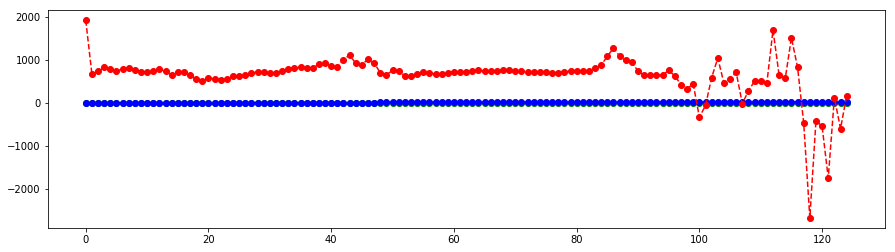

In [22]:
# unwrapped phase and instantaneous frequency!
print("phase unscaled [{}, {}]".format(np.amin(phase), np.amax(phase)))
unwrapped_phase = np.unwrap(phase)
unwrapped_phase = np.matmul(lin_mel_matrix, unwrapped_phase)
print(unwrapped_phase.shape)
rev_unwrapped_phase = np.angle(np.exp(1j * unwrapped_phase))
# for some reason, some signs are flipped
# print(np.count_nonzero((rev_unwrapped_phase - phase) > 1e-04))
# assert np.allclose(np.abs(rev_unwrapped_phase), np.abs(phase), rtol=0, atol=1e-04)

inst_freq = np.diff(unwrapped_phase, axis=1)/(2*np.pi)*sample_rate
rev_if = np.cumsum(np.concatenate((unwrapped_phase[:,:1], inst_freq*(2*np.pi)/sample_rate), axis=1), axis=1)
# assert np.allclose(rev_if, unwrapped_phase)

mode, _ = scipy.stats.mode(np.argmax(magnitude, axis=0))
mode = mode[0]
plt.figure(figsize=(15, 4))
plt.plot(range(125), phase[mode,:125], '--go')
plt.plot(range(125), unwrapped_phase[mode,:125], '--bo')
plt.plot(range(125), inst_freq[mode,:125], '--ro')

In [23]:
# scaled_phase = phase / (np.pi + epsilon)
print("phase unscaled [{}, {}]".format(np.amin(inst_freq), np.amax(inst_freq)))
print("phase scaled [{}, {}]".format(np.amin(inst_freq), np.amax(inst_freq)))

phase unscaled [-4398.898053470594, 4435.086225608824]
phase scaled [-4398.898053470594, 4435.086225608824]


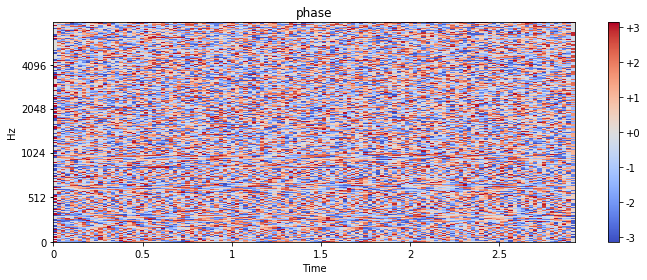

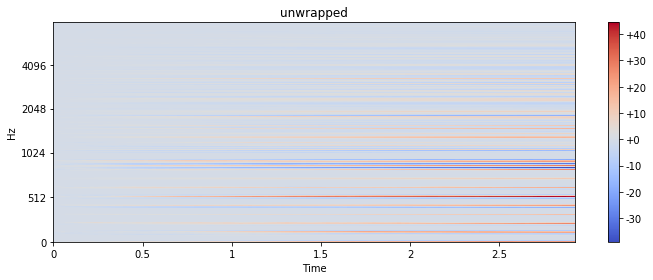

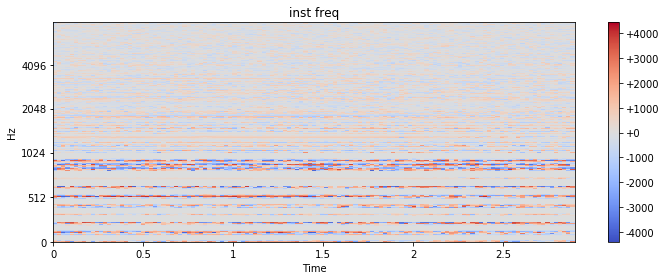

In [24]:
plt.figure(figsize=(10, 4))
librosa.display.specshow(phase, y_axis='mel', fmax=8000, x_axis='time')
plt.colorbar(format='%+2.0f')
plt.title('phase')
plt.tight_layout()

plt.figure(figsize=(10, 4))
librosa.display.specshow(unwrapped_phase, y_axis='mel', fmax=8000, x_axis='time')
plt.colorbar(format='%+2.0f')
plt.title('unwrapped')
plt.tight_layout()

plt.figure(figsize=(10, 4))
librosa.display.specshow(inst_freq, y_axis='mel', fmax=8000, x_axis='time')
plt.colorbar(format='%+2.0f')
plt.title('inst freq')
plt.tight_layout()

In [ ]:
final_iso = np.stack((magnitude, phase), axis=2)
print(final_iso.shape)

# sample_rate = 32000 sample_duration = 64000 n_fft = 2048 -> (1025, 126, 2)
# trim axis 1 and pad axis 2 to get 1024 (2^10), 128 (2^7)
# final_iso = final_iso[:-1, :, :]  # shape (1024, 173, 2)
print(final_iso.shape)
final_iso_pad = np.zeros((1024, 2, 2))  # TODO: account for magnitude don't just make 0
final_iso = np.concatenate((final_iso, final_iso_pad), axis=1)  # shape (1024, 128, 2)
print(final_iso.shape)